In [85]:
import numpy as np
from matplotlib import pyplot as plt
from model.MatrixRegressor import MatrixRegressor
from model.MatrixClassifier import MatrixClassifier
from model.MatrixTransfer import OracleTransReg
from model.utils import batch_mat_prod
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### **Generate Data**

In [2]:
def load_signal(path : str, show : bool=False) -> np.ndarray:
    beta = Image.open(path)
    beta = np.asarray(beta)[:,:,0]
    beta = (-beta + 255) / 255
    if show:
        fig = plt.figure(figsize=(4,4),dpi=50)
        plt.imshow(beta,cmap=plt.cm.OrRd)
    
    return beta

def DataGen(coef : np.ndarray, N : int=500):
    # dimension
    p, q = coef.shape[0], coef.shape[1]
    
    # Observations
    X = np.random.randn(N,p,q)
    # label
    y = batch_mat_prod(X,coef) + np.random.randn(N)
    
    return X,y

### **Simulations**

#### **(1) Circle**

load true signal

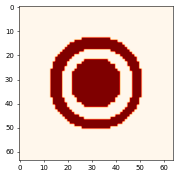

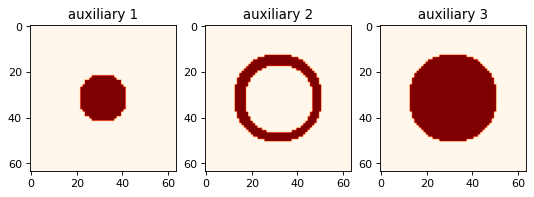

In [66]:
# true signal
beta = load_signal("./data/pattern/circle/circle_target.png",True)
# auxiliary signal
beta_aux = []
for i in range(3):
    beta_aux.append(load_signal("./data/pattern/circle/circle_aux%d.png"%(i+1),False))
fig,ax = plt.subplots(1,3,figsize=(8,24),dpi=80)
ax = ax.flatten()
for i in range(3):
    ax[i].imshow(beta_aux[i],cmap=plt.cm.OrRd)
    ax[i].set_title("auxiliary %d"%(i+1))

Generate training data

In [67]:
# target domain
Xt, yt = DataGen(beta,N=300)
# auxiliary domain
Xa, ya = [], []
for beta_ in beta_aux:
    X_aux, y_aux = DataGen(beta_,N=300)
    # add to auxiliary domain
    Xa.append(X_aux)
    ya.append(y_aux)

##### **Training Without Auxiliary Data**

Estimate variance of noise...
The estimated variance of noise is 0.01
Using BIC as criterion for regression task
Estimate Lipschitz constant...


Training for lambda = 29.00, Rank of the estimated coef : 2: 100%|██████████████████████| 25/25 [00:06<00:00,  3.61it/s]

Best penalty lambda is 5.0000


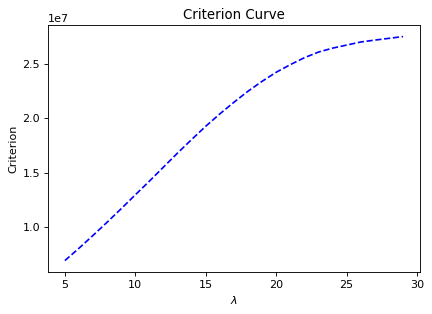

In [68]:
model = MatrixRegressor()
model.fit(X=Xt,y=yt,bound=[5,30],step=1,tau=1,show=True)

SSE:  207273.5110945201
rank:  23


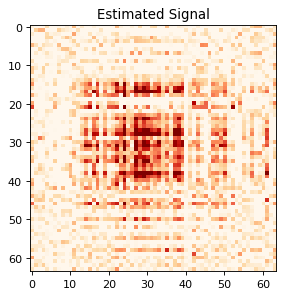

In [72]:
model_benchmark = MatrixRegressor(_lambda=20)
model_benchmark.optimize(Xt,yt)
print("SSE: ",np.sum((model_benchmark.predict(Xt) - yt)**2))
print("rank: ",np.sum(model_benchmark.singular_vals > 0))
model_benchmark.show_signal()

##### **Training With Auxiliary Data**

In [73]:
TransModel = OracleTransReg()
model = MatrixRegressor()
TransModel.fit(model,Xt=Xt,yt=yt,Xa=Xa,ya=ya,A=[0,1,2],bound=[1,20],step=1,tau=1000)

Penalty coef lambda is None, use criterion to set lambda automatically...
=========================== Estimate Omega on auxiliary datasets using Oracle Transfer Algo ===========================
Estimate variance of noise...
The estimated variance of noise is 0.10
Using BIC as criterion for regression task
Estimate Lipschitz constant...


Training for lambda = 19.00, Rank of the estimated coef : 2: 100%|██████████████████████| 19/19 [00:20<00:00,  1.06s/it]


Best penalty lambda is 1.0000

============================ Estimate Delta on target datasets using Oracle Transfer Algo =============================
Estimate variance of noise...
The estimated variance of noise is 0.01
Using BIC as criterion for regression task
Estimate Lipschitz constant...


Training for lambda = 19.00, Rank of the estimated coef : 6: 100%|██████████████████████| 19/19 [00:05<00:00,  3.55it/s]

Best penalty lambda is 1.0000


In [83]:
TransModel = OracleTransReg()
model = MatrixRegressor()
TransModel.fit(model,Xt=Xt,yt=yt,Xa=Xa,ya=ya,A=[0,1,2],_lambda=6)

Used specified lambda for training...


SSE of benchmark:  207273.5110945201
rank of benchmark:  23
SSE of transfer:  192749.56642538
rank of transfer:  43


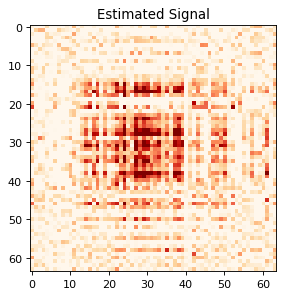

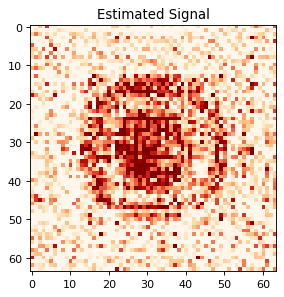

In [84]:
print("SSE of benchmark: ",np.sum((model_benchmark.predict(Xt) - yt)**2))
print("rank of benchmark: ",np.sum(model_benchmark.singular_vals > 0))
print("SSE of transfer: ",np.sum((model.predict(Xt) - yt)**2))
print("rank of transfer: ",np.sum(model.singular_vals > 0))
model_benchmark.show_signal()
model.show_signal()

# Classification

Text(0.5, 1.0, 'Letter: 5')

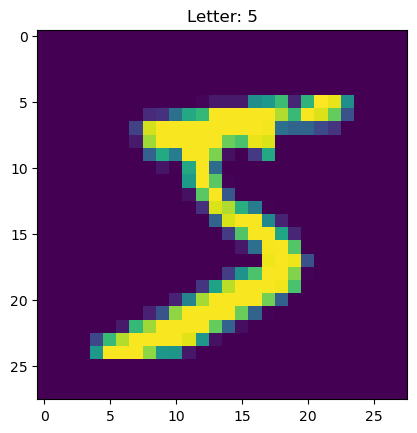

In [110]:
# fetch datasets
# X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = np.load("./data/mnist/data.npy")
y = np.load("./data/mnist/label.npy")
# print("Shape of the X: ",X.shape)

# show picture
plt.imshow(X[0].reshape(28,28))
plt.title("Letter: " + str(y[0]))

In [185]:
# split samples into training and testing
y_use = y.copy()
# y_use[y == 3] = 1
# y_use[y != 3] = 0
X_train, X_test, y_train, y_test = train_test_split(X, y_use, test_size=0.95, random_state=2022)
X_aux, X_test, y_aux, y_test = train_test_split(X_test, y_test, test_size=0.40, random_state=2022)
# do scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_aux = scaler.transform(X_aux)

# tranform into matrix
X_train = X_train.reshape((len(X_train),28,28))
X_test = X_test.reshape((len(X_test),28,28))
X_aux = X_aux.reshape((len(X_aux),28,28))

In [186]:
benchmark_model = MatrixClassifier(_lambda=0.2)
benchmark_model.optimize(X_train,y_train)
TransModel = OracleTransReg()
model = MatrixClassifier()
TransModel.fit(model,Xt=X_train,yt=y_train,Xa=[X_aux],ya=[y_aux],A=[0],_lambda=0.1)

Used specified lambda for training...


In [187]:
print("train accuracy: %.4f"%(benchmark_model.score(y_train,benchmark_model.predict(X_train))))
print("test accuracy: %.4f"%(benchmark_model.score(y_test,benchmark_model.predict(X_test))))
print("train accuracy: %.4f"%(model.score(y_train,model.predict(X_train))))
print("test accuracy: %.4f"%(model.score(y_test,model.predict(X_test))))

train accuracy: 0.9600
test accuracy: 0.6000
train accuracy: 0.7400
test accuracy: 0.6526


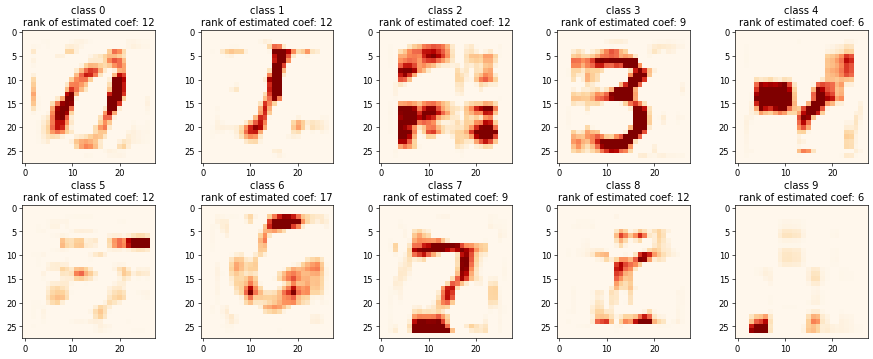

In [188]:
benchmark_model.show_signal(2,5)

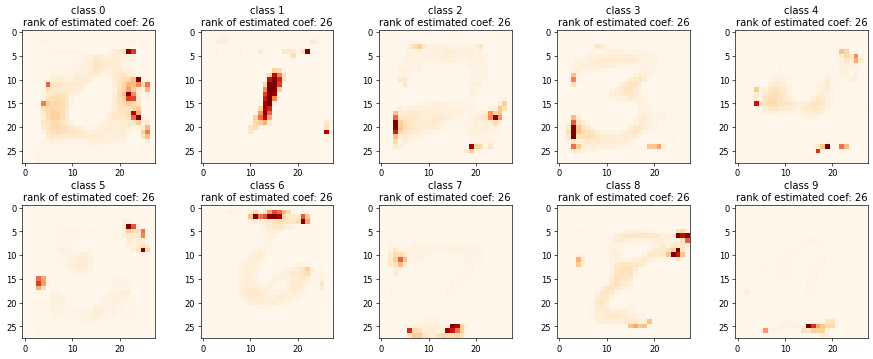

In [189]:
model.show_signal(2,5)